In [27]:
import sys
sys.path.append("../../..")
%load_ext autoreload
%autoreload 1
import lightning.pytorch as pl
import numpy as np
import mplhep as hep
plt.style.use(hep.style.CMS)

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
from hists.store import HistogramId
from HistogramLib.histogram import HistogramKind

%aimport ml.regression.tracksterProperties.tracksterProperties
from ml.regression.tracksterProperties.tracksterProperties import *

from energy_resolution.sigma_over_e import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
reader = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
datamodule = TracksterPropDataModule(reader)
model = TracksterPropModule(net=BasicHiddenLayerModel(hidden_size=10))

In [3]:
trainer = pl.Trainer(accelerator="gpu", devices=[1], enable_progress_bar=True, fast_dev_run=False, logger=False, max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
datamodule.setup("")

In [5]:
dataloader = datamodule.full_dataset_loader()

In [6]:
res = trainer.predict(model=model, dataloaders=dataloader, ckpt_path="/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/runs/tracksterProp-Jun12/lightning_logs/version_2/checkpoints/last.ckpt")

Restoring states from the checkpoint path at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/runs/tracksterProp-Jun12/lightning_logs/version_2/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/runs/tracksterProp-Jun12/lightning_logs/version_2/checkpoints/last.ckpt
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [7]:
import hist
h = hist.Hist(beamEnergiesAxis(), 
        hist.axis.Regular(bins=20000, start=0, stop=350, name="clus3D_mainTrackster_energy_pred", label="Main trackster energy, predicetd by NN (GeV)"))

In [8]:
from collections import defaultdict
values_dict = defaultdict(list)
for predictions, batch in zip(res, dataloader, strict=True):
    h.fill(batch[2], predictions)
    for pred, beamEnergy in zip(predictions.numpy(), batch[2].numpy(), strict=True):
        values_dict[beamEnergy].append(pred)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f112860d2d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

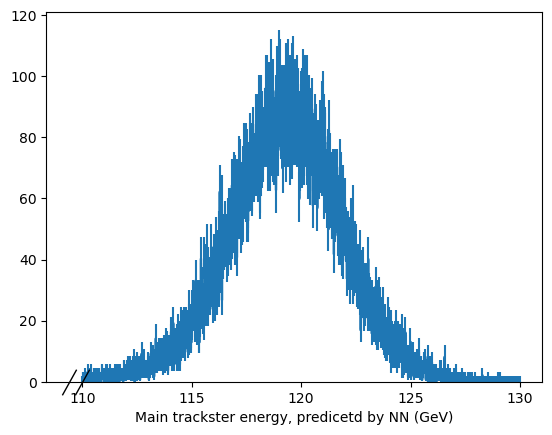

In [9]:
h[hist.loc(120), hist.loc(110):hist.loc(130)].plot()

In [11]:
sigmaMuResults = SigmaOverEComputations().compute(h, tqdm_dict=dict(disable=True), multiprocess=False)

Iterative fitting - 20 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 27 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 50 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 80 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 99 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 119 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 149 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 197 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 243 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 287 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

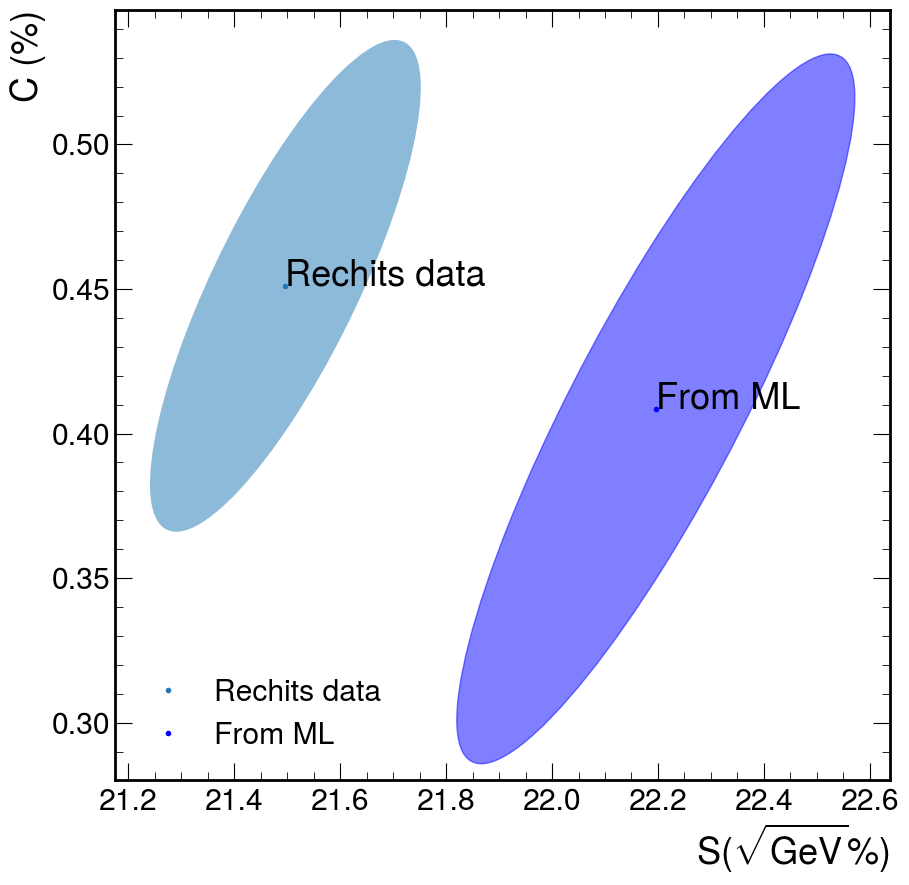

In [28]:
sigmaMuResults_without20 = sigmaMuResults.copy()
sigmaMuResults_without20.pop(20)
sigmaMuResults_without20.pop(30)
E_res_fitResult = fitSigmaOverE(sigmaMuResults_without20)
fig = plotSCAsEllipse([
    reader.loadSigmaOverEResults("rechits"),#._replace(legend="$\\frac{dE}{dx}$ weights (Data)")
    SigmaOverEPlotElement(legend="From ML", fitResult=E_res_fitResult)])

In [13]:
sigmaMuResults_without20

{50: SigmaMuResult(mu=50.005115617606826+/-0.015247652044086062, sigma=1.570787870407773+/-0.012209939890282758, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f103052f190>, fitQuality='good'),
 80: SigmaMuResult(mu=79.60453243467231+/-0.021545313795390143, sigma=2.019740955903048+/-0.017199089089045612, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f10301ee6e0>, fitQuality='good'),
 100: SigmaMuResult(mu=99.4428943386573+/-0.024726886949495253, sigma=2.2473929770490026+/-0.019717801150407697, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f106066f490>, fitQuality='good'),
 120: SigmaMuResult(mu=119.35133686492867+/-0.02812740479206398, sigma=2.440578160929434+/-0.02247251650737857, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f10104ae7d0>, fitQuality='good'),
 150: SigmaMuResult(mu=148.85477500716377+/-0.03247576274216714, sigma=2.841451295807002+/-0.025950828187219693, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f

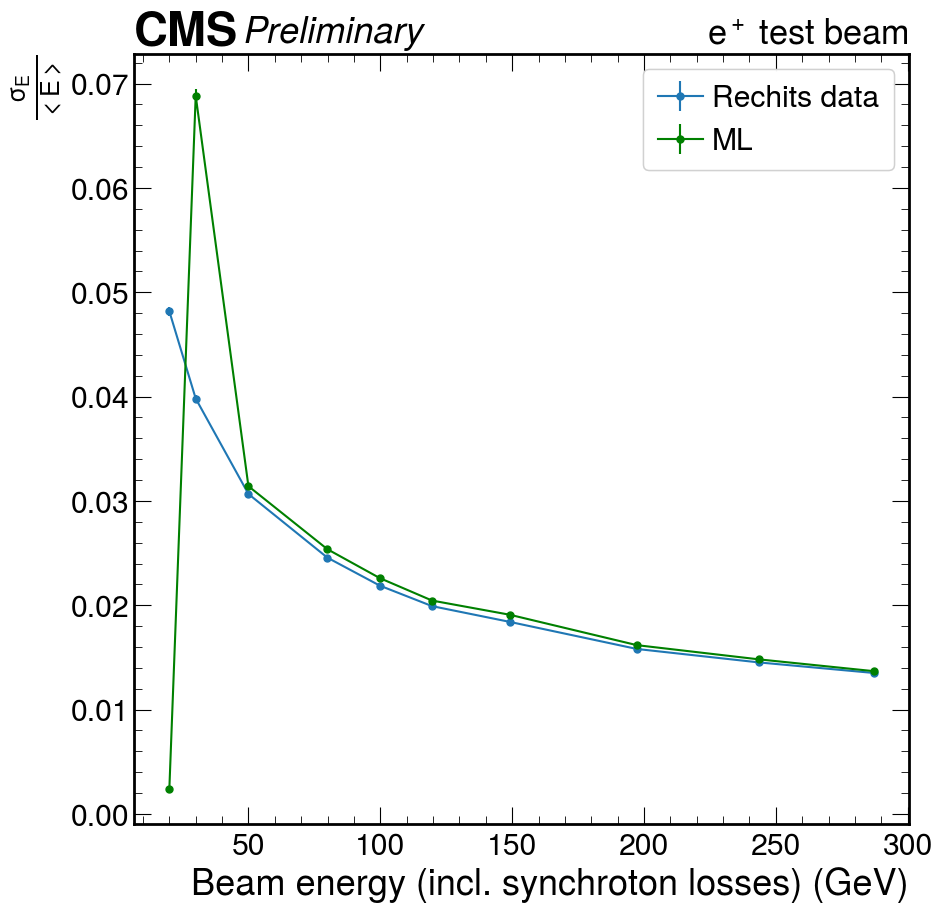

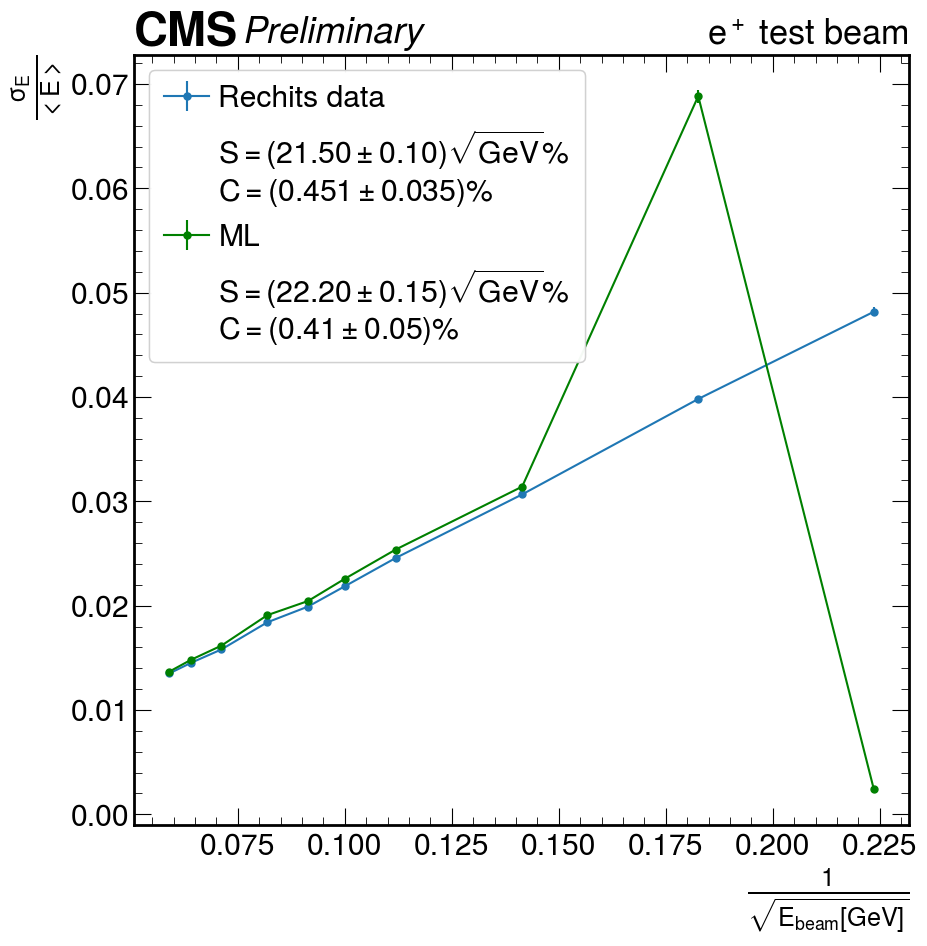

: 

In [30]:
plotSigmaOverMean([
        reader.loadSigmaOverEResults("rechits"),
        SigmaOverEPlotElement("ML", E_res_fitResult, sigmaOverE_fitFunction,  {beamEnergy : result.sigma / result.mu for beamEnergy, result in sigmaMuResults.items()}, color="green")
    ],
    xMode="E")
plotSigmaOverMean([
        reader.loadSigmaOverEResults("rechits"),
        SigmaOverEPlotElement("ML", E_res_fitResult, sigmaOverE_fitFunction,  {beamEnergy : result.sigma / result.mu for beamEnergy, result in sigmaMuResults.items()}, color="green")
    ],
    xMode="1/sqrt(E)")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0ff4761bd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

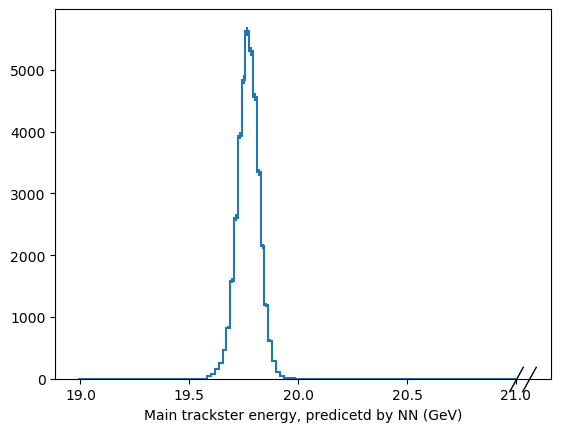

In [15]:
h[hist.loc(20), hist.loc(19):hist.loc(21)].plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f10c3c55840>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

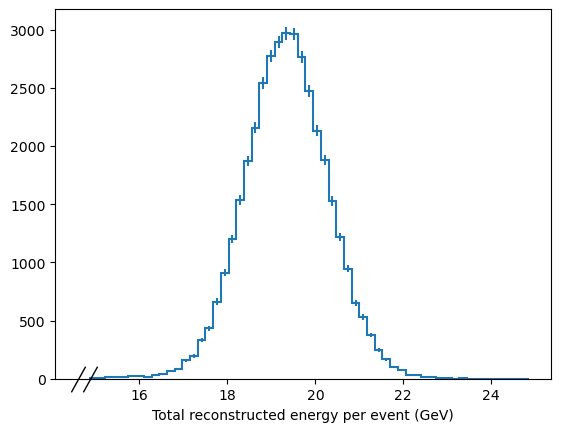

In [25]:
(reader.histStore.get(HistogramId("RechitsTotalEnergyPerEvent", reader.clueParams, reader.datatype))
.getHistogram(HistogramKind.COUNT)
[hist.loc(20), hist.loc(15):hist.loc(25)]
.plot()
)

Iterative fitting - 20 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

SigmaMuResult(mu=19.7710488736051+/-0.0004895436518337854, sigma=0.047159112880064025+/-0.0004210594623161956, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fcaa852b220>, fitQuality='good')

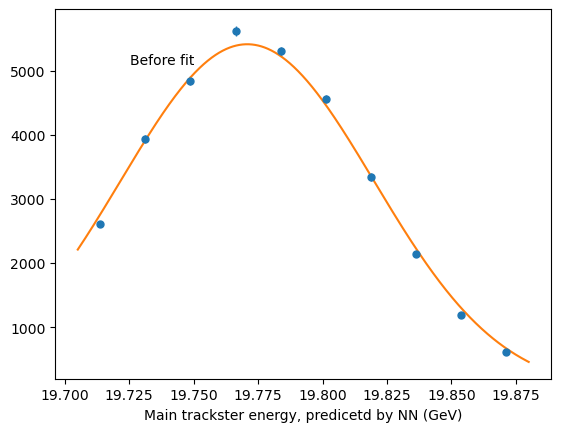

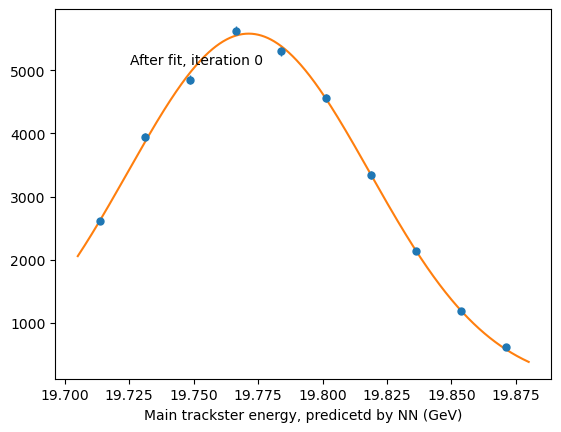

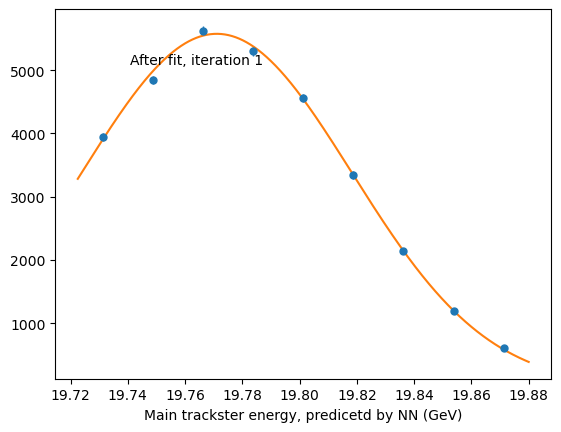

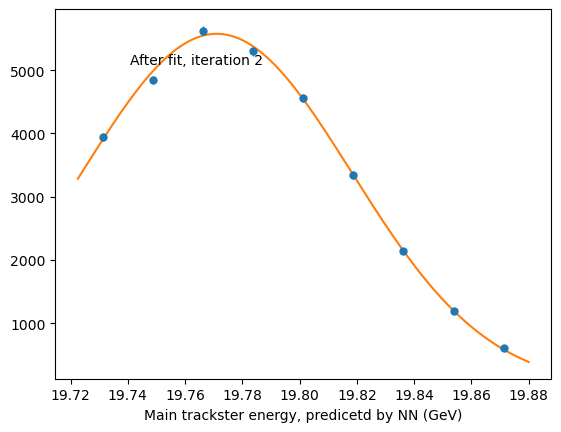

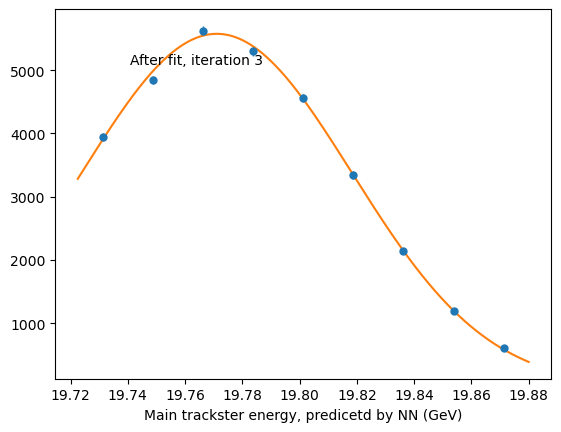

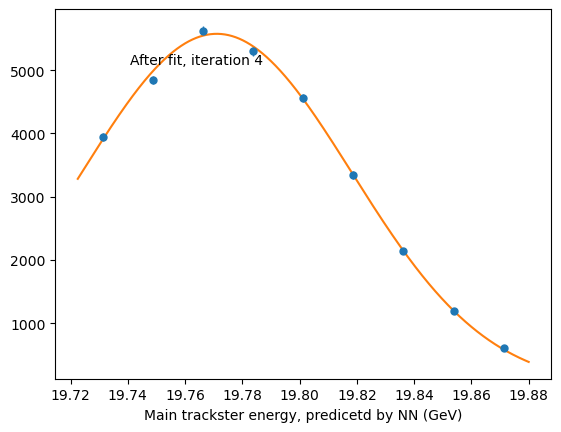

In [ ]:
SigmaOverEComputations(plotDebug=True).singleFit(h[hist.loc(20), :])

In [ ]:
sigmaMuResults

{20: SigmaMuResult(mu=19.7710488736051+/-0.0004895436518337854, sigma=0.047159112880064025+/-0.0004210594623161956, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fcb07998c40>, fitQuality='good'),
 50: SigmaMuResult(mu=50.005115617606826+/-0.015247652044086062, sigma=1.570787870407773+/-0.012209939890282758, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fcb07933220>, fitQuality='good'),
 80: SigmaMuResult(mu=79.60453243467231+/-0.021545313795390143, sigma=2.019740955903048+/-0.017199089089045612, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fcae020b910>, fitQuality='good'),
 120: SigmaMuResult(mu=119.35133686492867+/-0.02812740479206398, sigma=2.440578160929434+/-0.02247251650737857, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fcac84761a0>, fitQuality='good'),
 150: SigmaMuResult(mu=148.85477500716377+/-0.03247576274216714, sigma=2.841451295807002+/-0.025950828187219693, fitResult=<zfit.minimizers.fitresult.FitResult object at 0